# Seasonal Autoregressive Integrated Moving Averages - SARIMA(p,d,q)(P,D,Q)

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

Two libraries cover these models - [statsmodels](https://www.statsmodels.org/stable/index.html) and [darts](https://unit8co.github.io/darts/).  This notebook uses statsmodels.

ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting model that combines autoregressive (AR), differencing (I), and moving average (MA) components.

1. **AutoRegressive (AR)**: The AR component of ARIMA models the relationship between an observation and a number of lagged observations (i.e., observations at prior time steps). It captures the linear dependence between the current value and its previous values.

2. **Integrated (I)**: The I component represents differencing of the raw observations to make the time series stationary. Stationarity is essential for many time series forecasting techniques because it ensures that the statistical properties of the series, such as mean and variance, remain constant over time.

3. **Moving Average (MA)**: The MA component of ARIMA models the relationship between an observation and a residual error from a moving average model applied to lagged observations. It captures the relationship between the current value and a stochastic component based on past forecast errors.

ARIMA models are typically denoted by the notation ARIMA(p, d, q), where:
- **p**: The number of lag observations included in the model's autoregressive component.
- **d**: The number of times the raw observations are differenced to achieve stationarity.
- **q**: The size of the moving average window, or the number of lagged forecast errors included in the model's moving average component.

ARIMA models are widely used for time series forecasting in various fields such as economics, finance, meteorology, and engineering. They can be extended to handle seasonality and trends in the data through seasonal ARIMA (SARIMA) models. Parameter selection and model fitting in ARIMA involve statistical techniques like autocorrelation function (ACF) and partial autocorrelation function (PACF) analysis, along with tests for stationarity.

In a Seasonal Autoregressive Integrated Moving Average (SARIMA) model, the parameters extend those of the regular ARIMA model to account for seasonality in the time series data. Here's what each parameter in a SARIMA model typically represents:

1. **p (AR parameter)**: This parameter represents the number of lagged observations included in the model's autoregressive (AR) component, similar to the non-seasonal ARIMA model. It captures the relationship between the current observation and its previous observations within the same season.

2. **d (Integrated parameter)**: This parameter represents the degree of differencing required to make the time series stationary, similar to the non-seasonal ARIMA model.

3. **q (MA parameter)**: This parameter represents the number of lagged forecast errors included in the model's moving average (MA) component, similar to the non-seasonal ARIMA model.

4. **P (Seasonal AR parameter)**: This parameter represents the number of seasonal autoregressive terms, capturing the relationship between the current observation and its previous observations at the same lag in previous seasons.

5. **D (Seasonal Integrated parameter)**: This parameter represents the degree of seasonal differencing required to make the time series stationary, similar to the non-seasonal ARIMA model.

6. **Q (Seasonal MA parameter)**: This parameter represents the number of seasonal moving average terms, capturing the relationship between the current observation and its previous forecast errors at the same lag in previous seasons.

7. **s (Seasonal period)**: This parameter indicates the periodicity of the seasonality in the time series data. It defines the number of observations per seasonal cycle. For example, if the data is monthly and exhibits yearly seasonality, then s would be 12.

So, in summary:

- **p, d, q**: Non-seasonal ARIMA parameters.
- **P, D, Q**: Seasonal ARIMA parameters.
- **s**: Seasonal period.

These parameters are determined through methods like autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, along with seasonal differencing and statistical tests for stationarity. Tuning these parameters effectively is crucial for building an accurate SARIMA model for time series forecasting, especially when dealing with seasonal data patterns.

In [41]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('data/co2_mm_mlo.csv')

In [42]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [43]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Freq: MS
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          729 non-null    int64  
 1   month         729 non-null    int64  
 2   decimal_date  729 non-null    float64
 3   average       722 non-null    float64
 4   interpolated  729 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.2 KB


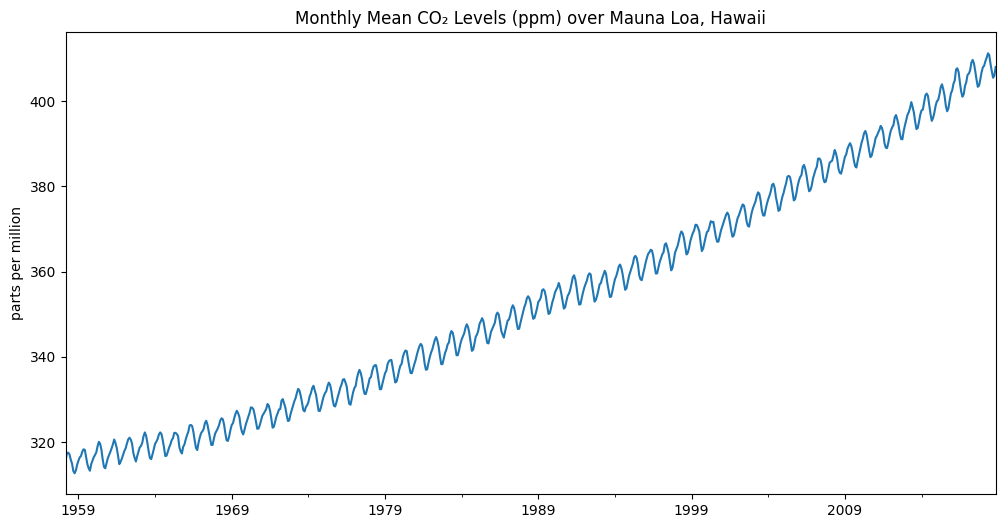

In [45]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

#fills in missing values 9 in interpolated
ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

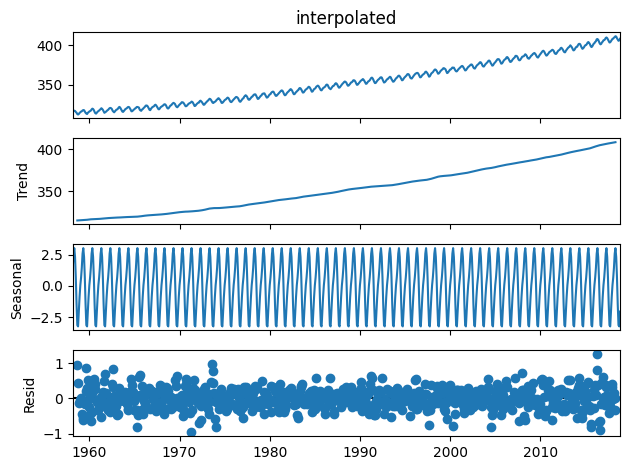

In [46]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

## Get the parameters

In [37]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.686
Date:                              Sat, 16 Mar 2024   AIC                            423.371
Time:                                      11:47:24   BIC                            450.913
Sample:                                  03-01-1958   HQIC                           433.998
                                       - 11-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.035    -10.106      0.000      -0.425      -0.287
ma.L2         -0.0222      0.035     -0.640      0.522      -0.090       0.046
ma.L3         -0.0856      0.027     -3.161      0.002      -0.139      -0.033
ar.S.L12       0.9996      0.000   3060.520      0.000       0.999       1.000
ma.S.L12      -0.8670      0.021    -40.929      0.000      -0.909      -0.826
sigma2         0.0955      0.005     20.528      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.79   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.

## Split the data into train/test sets

In [38]:
len(df)

729

In [47]:
# Set one year for testing - imporant - use the latest data for the best forecasting
train = df.iloc[:717]
test = df.iloc[717:]
len(test)

12

In [40]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17036D+00    |proj g|=  7.04673D-01


 This problem is unconstrained.



At iterate    5    f=  3.17640D-01    |proj g|=  4.51830D-01

At iterate   10    f=  2.89552D-01    |proj g|=  1.79159D-03

At iterate   15    f=  2.89352D-01    |proj g|=  1.42306D-02

At iterate   20    f=  2.84824D-01    |proj g|=  2.24823D-02

At iterate   25    f=  2.80674D-01    |proj g|=  1.06937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     51      1     0     0   2.295D-03   2.806D-01
  F =  0.28060260479584037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.192
Date:                              Sat, 16 Mar 2024   AIC                            414.384
Time:                                      11:52:11   BIC                            441.826
Sample:                                  03-01-1958   HQIC                           424.981
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3535      0.034    -10.424      0.000      -0.420      -0.287
ma.L2         -0.0240      0.016     -1.508      0.132      -0.055       0.007
ma.L3         -0.0895      0.022     -4.042      0.000      -0.133      -0.046
ar.S.L12       0.9996      0.000   2866.879      0.000       0.999       1.000
ma.S.L12      -0.8653      0.023    -38.040      0.000      -0.910      -0.821
sigma2         0.0951      0.005     20.242      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 4.32
Prob(Q):                              0.76   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

In [49]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6107726, expected=406.81
predicted=407.8265757, expected=407.96
predicted=408.580304 , expected=408.32
predicted=409.4854398, expected=409.41
predicted=411.0435628, expected=410.24
predicted=411.6468702, expected=411.24
predicted=410.8661934, expected=410.79
predicted=409.175458 , expected=408.71
predicted=407.0750855, expected=406.99
predicted=405.625016 , expected=405.51
predicted=405.8961315, expected=406.0
predicted=407.4303905, expected=408.02


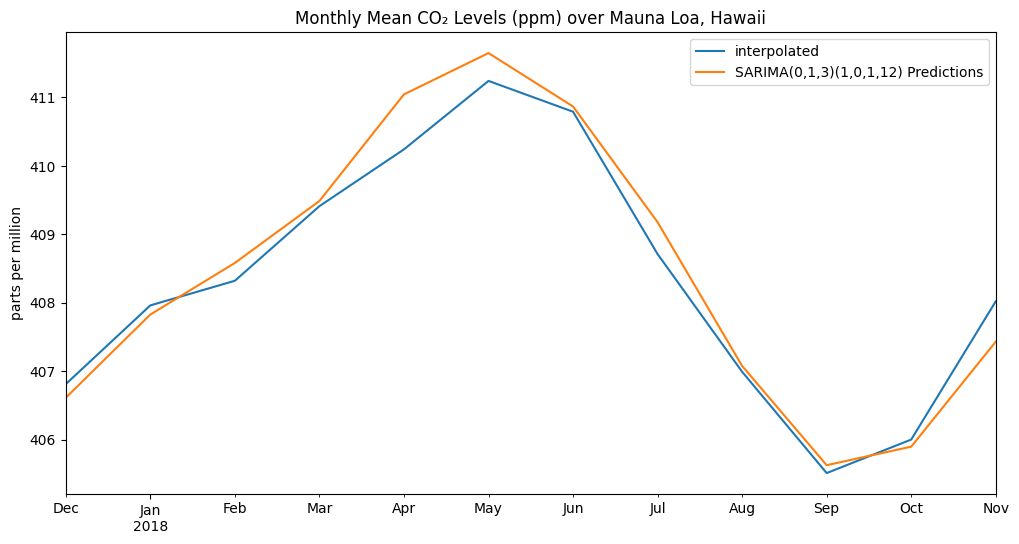

In [50]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Evaluate model

In [51]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1286293578


In [52]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f' RMSE Error: {error:11.10}')

 RMSE Error: 0.3586493521


## Forecast the future

** RETRAIN ON ALL DATA **

In [53]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))  
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16665D+00    |proj g|=  7.00517D-01


 This problem is unconstrained.



At iterate    5    f=  3.24405D-01    |proj g|=  5.30846D-01

At iterate   10    f=  3.06196D-01    |proj g|=  9.11449D-03

At iterate   15    f=  3.05613D-01    |proj g|=  4.19830D-02

At iterate   20    f=  2.94958D-01    |proj g|=  9.47968D-02

At iterate   25    f=  2.83139D-01    |proj g|=  3.81838D-02

At iterate   30    f=  2.82152D-01    |proj g|=  1.02297D-03

At iterate   35    f=  2.82148D-01    |proj g|=  7.62983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     63      1     0     0   1.232D-04   2.821D-01
  F =  0.28214759620002317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

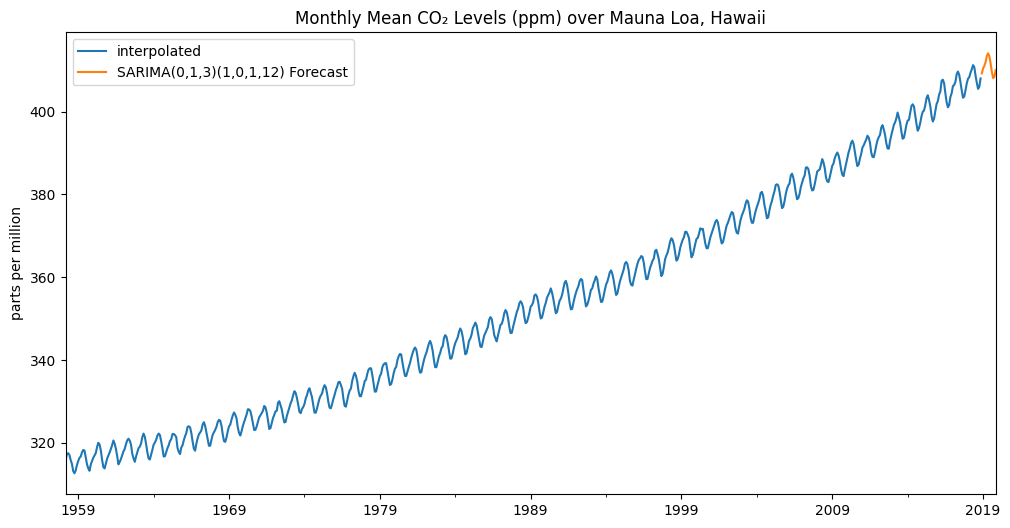

In [54]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors - SARIMAX

Adding in a useful external feature
SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous factors. It is an extension of the seasonal ARIMA (SARIMA) model that allows for the inclusion of additional exogenous variables, also known as covariates or regressors, in the forecasting process.

The SARIMAX model incorporates both the seasonal and non-seasonal components of ARIMA, while also considering the impact of external factors on the time series being forecasted. These external factors could be other time series variables, indicators, or predictors that may influence the target variable.

The general equation for a SARIMAX(p, d, q)(P, D, Q)s model with \( k \) exogenous variables can be expressed as:

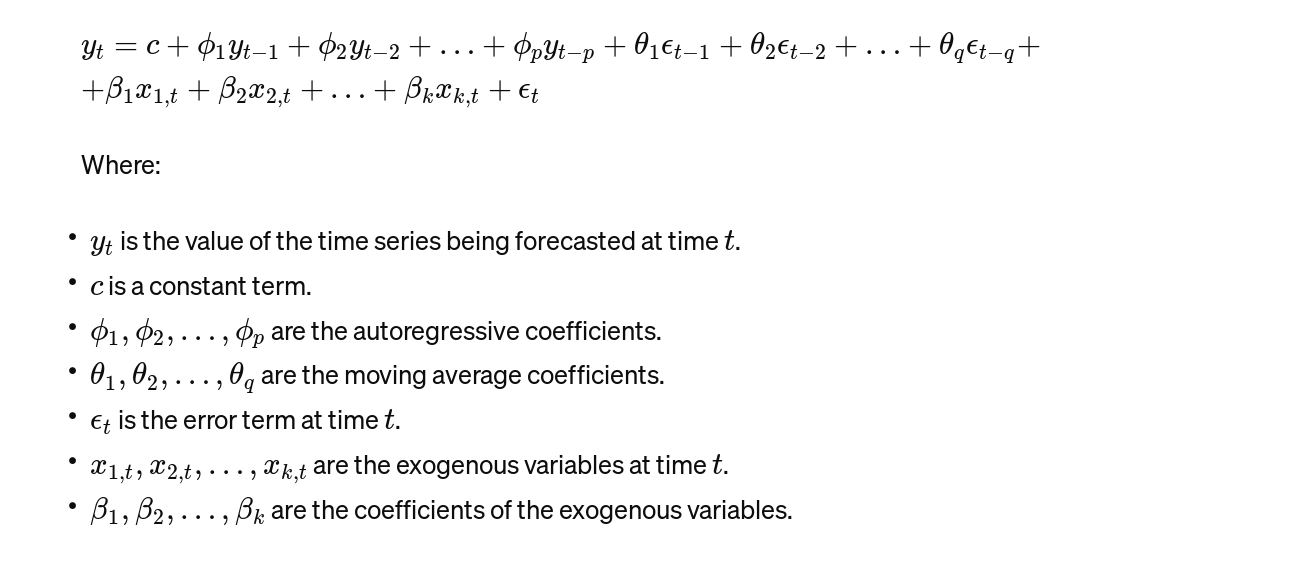

SARIMAX models are useful when there are known external factors that can improve the forecasting accuracy of the time series of interest. These external variables can capture additional information not accounted for by the ARIMA components alone, leading to more accurate predictions.

Estimation and inference in SARIMAX models involve fitting the model parameters, including both the ARIMA and exogenous variables coefficients, typically using maximum likelihood estimation or other optimization techniques. These models can be particularly powerful in scenarios where the behavior of the time series is influenced by both internal dynamics and external factors.

In [55]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

In [56]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [57]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [58]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [59]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


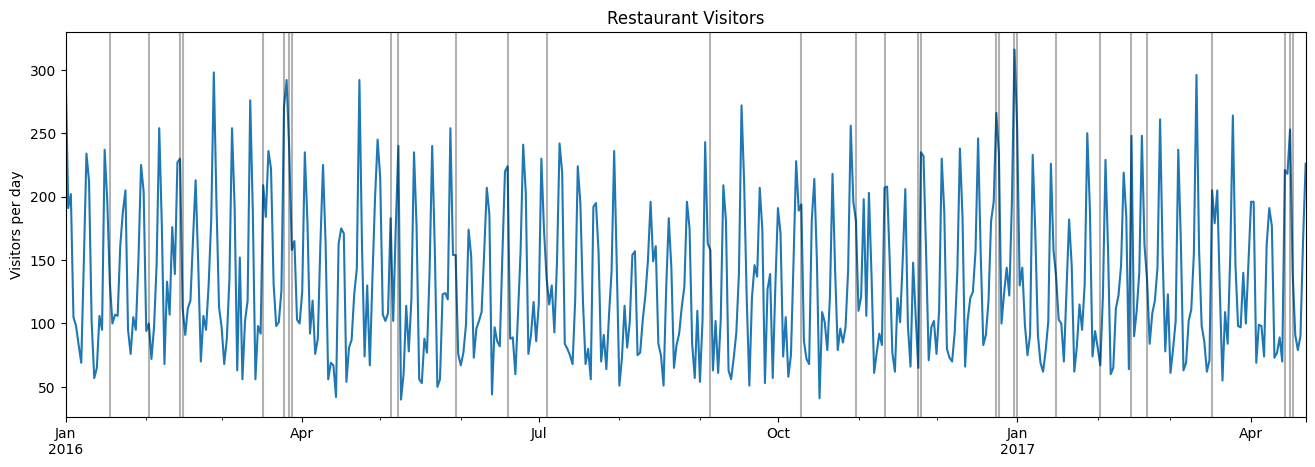

In [60]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

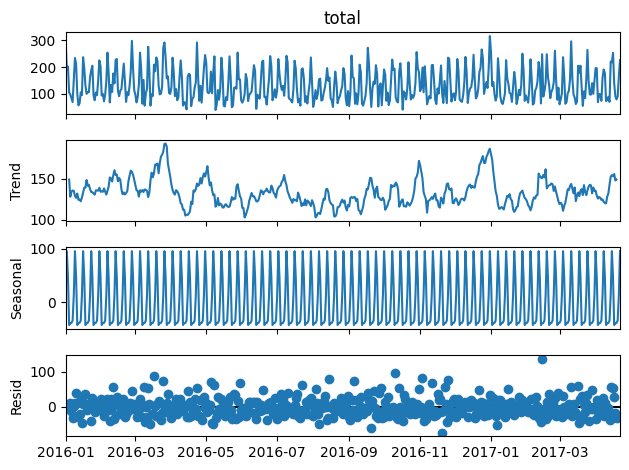

In [61]:
result = seasonal_decompose(df1['total'])
result.plot();

In [62]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2381.598
Date:                   Sat, 16 Mar 2024   AIC                           4771.197
Time:                           12:08:48   BIC                           4787.875
Sample:                       01-01-2016   HQIC                          4777.754
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3650      1.674      2.607      0.009       1.083       7.647
ar.S.L7        0.9661      0.013     76.835      0.000       0.942       0.991
ma.S.L7       -0.7541      0.051    -14.801      0.000      -0.854      -0.654
sigma2      1269.4981     78.083     16.258      0.000    1116.459    1422.537
===================================================================================
Ljung-Box (L1) (Q):                  15.35   Jarque-Bera (JB):                63.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split Data

In [63]:
len(df1)


478

In [75]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]
len(test)


42

In [76]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33146D+00    |proj g|=  1.63833D-01

At iterate    5    f=  5.29853D+00    |proj g|=  1.98899D-02

At iterate   10    f=  5.26162D+00    |proj g|=  1.00307D+00

At iterate   15    f=  5.23418D+00    |proj g|=  1.51131D-02

At iterate   20    f=  5.22822D+00    |proj g|=  9.84715D-02

At iterate   25    f=  4.98152D+00    |proj g|=  1.91462D-01

At iterate   30    f=  4.96264D+00    |proj g|=  6.73686D-03

At iterate   35    f=  4.95785D+00    |proj g|=  1.03420D-01

At iterate   40    f=  4.94516D+00    |proj g|=  7.37075D-02

At iterate   45    f=  4.94387D+00    |proj g|=  1.43137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2155.511
Date:                             Sat, 16 Mar 2024   AIC                           4319.023
Time:                                     12:14:02   BIC                           4335.333
Sample:                                 01-01-2016   HQIC                          4325.460
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2194      0.043      5.066      0.000       0.135       0.304
ar.S.L7        0.9999      0.000   8027.776      0.000       1.000       1.000
ma.S.L7       -0.9405      0.023    -40.029      0.000      -0.987      -0.894
sigma2      1068.8594     54.344     19.668      0.000     962.346    1175.372
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               106.77
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predictions')

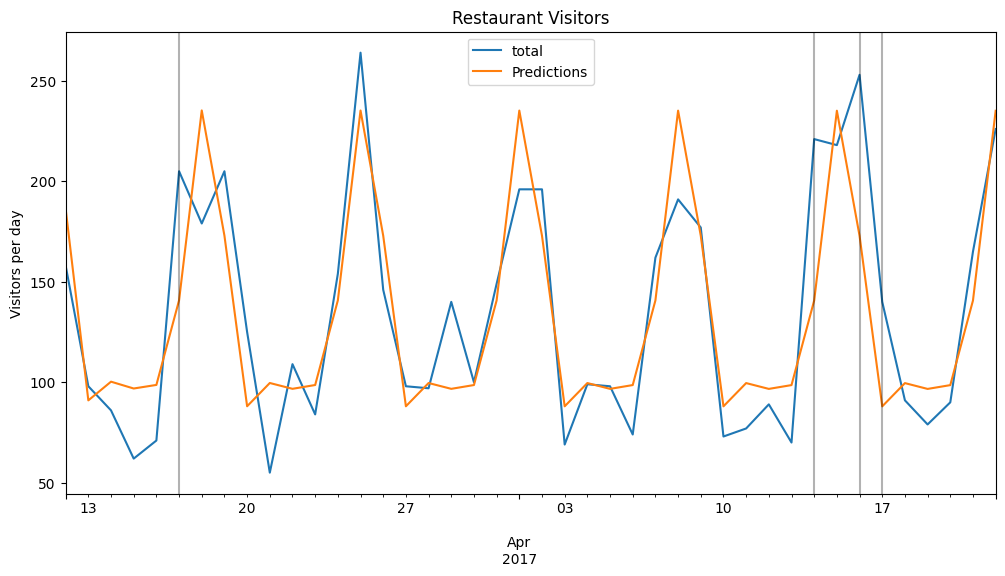

In [78]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Evaluate without the extra feature

In [79]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f' MSE Error: {error1:11.10}')
print(f' RMSE Error: {error2:11.10}')

 MSE Error: 1022.090597
 RMSE Error: 31.97015165


## Add in extra featuer - Holidays

In [80]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52875D+00    |proj g|=  1.72995D-01

At iterate    5    f=  5.43727D+00    |proj g|=  7.88960D-02

At iterate   10    f=  5.40956D+00    |proj g|=  2.86539D-01

At iterate   15    f=  5.18546D+00    |proj g|=  6.28689D-02

At iterate   20    f=  5.17678D+00    |proj g|=  1.51121D-02

At iterate   25    f=  5.14577D+00    |proj g|=  2.45517D-01

At iterate   30    f=  4.79296D+00    |proj g|=  7.26695D-02

At iterate   35    f=  4.79176D+00    |proj g|=  2.21721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Sat, 16 Mar 2024   AIC                           4188.417
Time:                                     12:14:20   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9353      3.773     18.271      0.000      61.541      76.330
ar.L1          0.2101      0.044      4.762      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3164     44.867     17.370      0.000     691.379     867.254
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                20.47
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

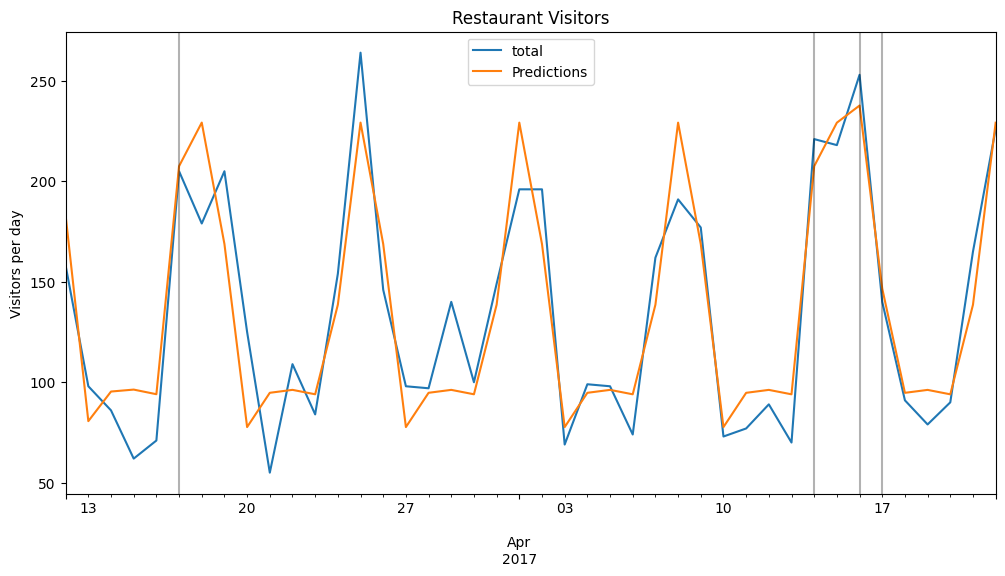

In [82]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Evaluate with the new feature

In [83]:
# Print values from SARIMA above
print(f'Without Feature -  MSE Error: {error1:11.10}')
print(f'Without Feature -  RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'With Feature -  MSE Error: {error1x:11.10}')
print(f'With Feature -  RMSE Error: {error2x:11.10}')

Without Feature -  MSE Error: 1022.090597
Without Feature -  RMSE Error: 31.97015165

With Feature -  MSE Error: 525.7736141
With Feature -  RMSE Error:  22.9297539


# Forcast the future via retraining model and extra feature and ALL data

In [73]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename(' Forecast')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52444D+00    |proj g|=  1.70479D-01

At iterate    5    f=  5.47083D+00    |proj g|=  1.08907D+00

At iterate   10    f=  5.43772D+00    |proj g|=  2.82524D-02

At iterate   15    f=  5.43656D+00    |proj g|=  4.86868D-02

At iterate   20    f=  5.40831D+00    |proj g|=  2.14017D-01

At iterate   25    f=  5.22026D+00    |proj g|=  2.62879D-01

At iterate   30    f=  5.17200D+00    |proj g|=  4.51710D-03

At iterate   35    f=  5.14775D+00    |proj g|=  2.24710D-01

At iterate   40    f=  4.81362D+00    |proj g|=  3.74282D-01

At iterate   45    f=  4.77745D+00    |proj g|=  3.93832D-03

At iterate   50    f=  4.77735D+00    |proj g|=  3.28948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

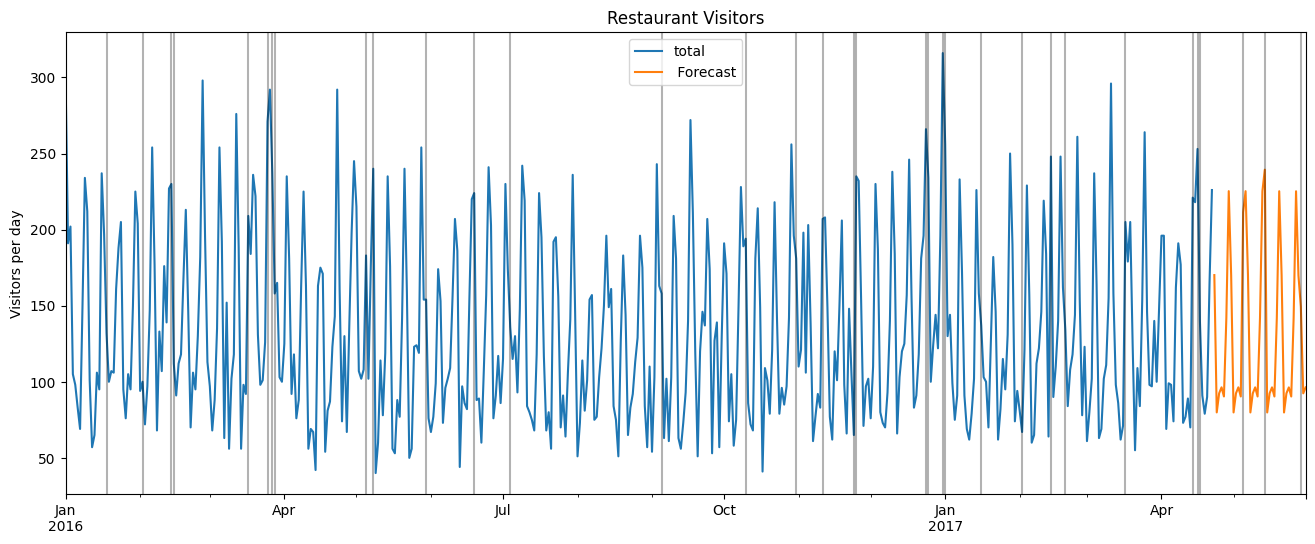

In [74]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);